#Análisis Central Telefónica Zohoo-ANURA

### Librerías utilizadas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Montado cuenta de Drive

In [2]:
# Conecto con drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Análisis Exploratorio de Datos (AED)


---



## Tomar los datos desde el panel de **Anura**

Panel de Anura:

*   https://panel.anura.com.ar/#/index/users

* Una ves logueados tomar los datos desde el menú Estadítica > Grupos > Soporte.
* Definir rango de fecha (**NO** se puede pedir un rango **superior a 6 meses**).
* Considerando el punto anterior, voy armando manualmente el cdrs.csv tomando parciales.
* Una vez armado lo almacenamos en la carpeta /etsol/ds/ dentro de Google Drive con el nombre cdrs.csv.

In [3]:
# Cargo Data frame original exportado desde Anura
# verifico la dimensión del DS original

df = pd.read_csv('//content/drive/My Drive/Colab Notebooks/etsol/ds/cdrs.csv', sep=',' , encoding='unicode_escape')  # encoding='latin-1'    'unicode_escape'
df.shape


(50306, 22)

In [4]:
# No es necesario ejecutarlo ya que una vez que lo trabajamos debería NO cambiar.
# Considerar si se presenta un error en la depuración que viene después
df.head(5)

,Fecha,DirecciÃ³n,Nro. Origen,Origen,Nro. Destino,Destino,Estado,DuraciÃ³n total,DuraciÃ³n conversaciÃ³n,Tiempo espera,...,Cola nombre,Cola estado,Cola duraciÃ³n total,Cola duraciÃ³n conversaciÃ³n,Cola tiempo espera,Cola agente,Cola terminal agente,Cuenta contestÃ³,Terminal contestÃ³,Departamento
0,2021-05-26 17:31:09.17,IN,1154838143,Argentina/AMBA - MOVIL,116,Soporte,ANSWER,12,4,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doris Berman,softphone-107,Mesa de Soporte
1,2021-05-27 11:49:21.764,IN,3434281165,Argentina/PARANA - MOVIL,116,Soporte,ANSWER,51,22,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
2,2021-05-27 11:50:13.19,OUT,3434281165,NaN,116,Soporte,ANSWER,33,23,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
3,2021-05-27 11:50:13.27,IN,3434281165,Argentina/PARANA - MOVIL,116,Soporte,ANSWER,33,23,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Christian Saluzzo,softphone-109,Mesa de Soporte
4,2021-05-27 19:52:18.187,IN,1154838143,Argentina/AMBA - MOVIL,116,Soporte,ANSWER,60,51,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mariela Tomasini,softphone-106,Mesa de Soporte


#**Depuración del dataset cdrs.csv**


---

- "Fecha" separar en "Fecha" y "Hora"
- "Origen" --> separar Argentina/SAN NICOLAS - MOVIL
- **NUEVO** "Direccion" --> analizaremos IN.
- "Cuenta contestÃ³" reemplazaremos las NaN por "Perdidas" luego reemplazaremos el nombre de la etiqueta por CuentaContesto.
- ***Generar:***
- "FranjaHoraria" --> valores desde 8 a 19 indican la hora que cubre la Mesa de Ayuda.
- "Turno" --> toma el valor **1** (mañana 8 a 13:59) y **2** (tarde 14 a 19)
- "Turno-Tel" --> toma el valor **1** (mañana 8 a 17:00) y **2** (tarde 17:01 a 20)
- "Turno-Tel_2" --> toma el valor **1** (mañana 8 a 12:00) y **2** (tarde 12:01 a 20)  --  **"NUEVO"**
- "DiaSemana"  --> lunes, martes, miércoles, jueves, viernes, sábado
- "Provincia" --> generar las Provincias de Argentina
- "Region" --> Dividimos el país en Regiones sur, norte, centro, buenos aires y cuyo.
- ***Eliminar:***
- "Nro. Destino"
- "Destino"
- "Estado"
- "Precio"
- "Ultima acción"
- "Cola nombre"
- "Cola estado"
- "Cola duración total"
- "Cola duración conversación"
- "Cola tiempo espera"
- "Cola agente"
- "Cola terminal agente"
- "Departamento"

In [5]:
# Separar el campo "Fecha" en --> "Fecha" y "Hora"
# Eliminar el campo 'Fecha ' ojo que quedará el generado 'Fecha'
# Generamos el campo "FranjaHoraria" tomando sólo la hora. --> valores desde 8 a 19 horario que cubre la Mesa de Ayuda.
# comenzamos a modelar el df (es el que vamos a utilizar para trabajar en lo análisis finales)

df['Fecha'] = pd.to_datetime(df['Fecha ']).dt.date
df['Hora'] = pd.to_datetime(df['Fecha ']).dt.time
df['FranjaHoraria'] = pd.to_datetime(df['Fecha ']).dt.hour

"""
df = df.drop(df[df['FranjaHoraria'] == 7].index)  # Eliminar filas donde 'FranjaHoraria' cumple una condición específica
df = df.drop(df[df['FranjaHoraria'] == 21].index)  # Eliminar filas donde 'FranjaHoraria' cumple una condición específica
df = df.drop(df[df['FranjaHoraria'] == 22].index)  # Eliminar filas donde 'FranjaHoraria' cumple una condición específica
"""

df = df.drop(['Fecha '], axis='columns')


# "Origen" --> separar Argentina/SAN NICOLAS - MOVIL
# Esto por el momento no sé si tiene sentido hacerlo, lo dejaríamos para analizar luego


# "Direccion" --> Incorporamos además de los IN los OUT también para analizar la disponibilidad de los recursos que atienden.
# Es importante porque se perdía la disponibilidad del agente viendo solamente la atención de entradas "IN"
# Luego de filtrarlos; elimino la columna 'DirecciÃ³n '
""" ---------- Sacamos todo este código ----------"""
"""df = df[df['DirecciÃ³n '] == 'IN']"""
"""df = df[(df['DirecciÃ³n '] == 'IN') | (df['DirecciÃ³n '] == 'OUT')]
df = df.drop(['DirecciÃ³n '], axis='columns')"""

# Para poder trabajar las "Llamadas perdidas" reemplazaremos los valores nulos (NaN) de CuentaContesto a "PerdidasAnura"
df['Cuenta contestÃ³'].fillna('PerdidasAnura', inplace=True)

# "Nro. Origen" sacamos los valores 0, 112, 900
# Son internos que no vamos a considerar en los análisis
df = df[df['Nro. Origen '] != 0 ]   #  and df['Nro. Origen '] != 112 and df['Nro. Origen '] != 900]
df = df[df['Nro. Origen '] != 112 ]
df = df[df['Nro. Origen '] != 900 ]


# Generamos un nuevo campo "Turno" con los valores:
#    1 --> para los valores entre 8 y 13hs.
#    2 --> para los valores entre 14 y 20hs.
df['Turno'] = [1 if ( s>=8 and s<14) else 2 for s in df['FranjaHoraria']]

# Generamos un nuevo campo "Turno-Tel" con los valores:
#    1 --> para los valores entre 8 y 15:59hs.
#    2 --> para los valores entre 16 y 20hs.
df['Turno-Tel'] = [1 if ( s>=8 and s<17) else 2 for s in df['FranjaHoraria']]

df['Turno-Tel_2'] = [1 if ( s>=8 and s<12) else 2 for s in df['FranjaHoraria']]


# Generamos "DiaSemana" --> lunes, martes, miércoles, jueves, viernes, sábado
df['Fecha'] = pd.to_datetime(df['Fecha']) # convertimos la columna Fecha en datetime para poder calcular el día de la semana
df['DiaSemana'] = df['Fecha'].dt.day_name()

# Generar "Provincia" --> generar las Provincias de Argentina


# Generar "Region" --> Dividimos el país en Regiones sur, norte, centro, buenos aires y cuyo.


# Eliminación de las columnas que NO utizamos
df = df.drop(['Nro. Destino ','Destino ','Estado ', 'Precio','Ultima acciÃ³n','Cola nombre', 'Cola estado','Cola duraciÃ³n total','Cola duraciÃ³n conversaciÃ³n','Cola tiempo espera','Cola agente','Cola terminal agente','Departamento'], axis='columns')
df.shape


# Cambiamos los nombres de las columnas DirecciÃ³n , DuraciÃ³n total y  DuraciÃ³n conversaciÃ³n
df.columns.values[0] = "Direccion"
df.columns.values[3] = "DuracionT"
df.columns.values[4] = "DuracionConv"
df.columns.values[6] = "CuentaContesto"
df.columns.values[7] = "TerminalContesto"


In [6]:
df.head(5)

# Genero un archivo de excel para trabajarlo. Acá tengo los datos depurados
#df.to_excel('df_completo_depurado.xlsx', index=False)


,Direccion,Nro. Origen,Origen,DuracionT,DuracionConv,Tiempo espera,CuentaContesto,TerminalContesto,Fecha,Hora,FranjaHoraria,Turno,Turno-Tel,Turno-Tel_2,DiaSemana
0,IN,1154838143,Argentina/AMBA - MOVIL,12,4,8,Doris Berman,softphone-107,2021-05-26,17:31:09.170000,17,2,2,2,Wednesday
1,IN,3434281165,Argentina/PARANA - MOVIL,51,22,29,PerdidasAnura,NaN,2021-05-27,11:49:21.764000,11,1,1,1,Thursday
2,OUT,3434281165,NaN,33,23,10,PerdidasAnura,NaN,2021-05-27,11:50:13.190000,11,1,1,1,Thursday
3,IN,3434281165,Argentina/PARANA - MOVIL,33,23,10,Christian Saluzzo,softphone-109,2021-05-27,11:50:13.270000,11,1,1,1,Thursday
4,IN,1154838143,Argentina/AMBA - MOVIL,60,51,9,Mariela Tomasini,softphone-106,2021-05-27,19:52:18.187000,19,2,2,2,Thursday


# Filtros por fecha considerando lo que quiero analizar.
## Sólo ejecutar si queremos trabajar un Rango de fecha diferente

SI queremos ***analizar el histórico***, ***NO corremos estas líneas*** usamos el df como viene desde el inicio.

In [7]:
# Generamos un DF con un rango de fechas según el caso.

# Un MES determinado.
"""df = df[(df['Fecha'].dt.month == 3) & (df['Fecha'].dt.year == 2024)]"""

# Un DIA determinado
"""df = df[(df['Fecha'].dt.month ==3) & (df['Fecha'].dt.year == 2023) & (df['Fecha'].dt.day == 23)]"""

# Fecha DESDE y Fecha HASTA
fecha_desde = '2024-05-11'
fecha_hasta = '2024-05-11'
df = df[(df['Fecha'] >= fecha_desde) & (df['Fecha'] <= fecha_hasta)]

# /////// en caso de necesitar analizar desde el archivo de Excel
# Genero el archivo de excel para trabajarlo

df.to_excel('df_con_rango.xlsx', index=False)

# ⭐ INFORMES FINALES

---


# ⏰ Rango de fechas del "DS"

In [8]:
# Tomo las fechas de inicio y fecha final para poder establecer los rangos y maquetarlos en las gráficas.
fecha_minima = df['Fecha'].min().strftime('%Y-%m-%d')  # utilizamos strftime('%Y-%m-%d') para quitar la hora que me muestra.
fecha_maxima = df['Fecha'].max().strftime('%Y-%m-%d')  # idem
print("El rango de fechas es desde: \n {} hasta {}".format(fecha_minima, fecha_maxima))

El rango de fechas es desde: 
 2024-05-11 hasta 2024-05-11


## **Cantidad** de llamadas entrantes "**IN**".
(por franja horaria)

* He definido 3 umbrales (thresholds) y
* 3 colores correspondientes (color_palette).
* **Rojo** picos de llamadas se necesitan 4 recursos al teléfono.
* **Amarillo** intermedios.
* **Verde** picos bajos de llamadas. :

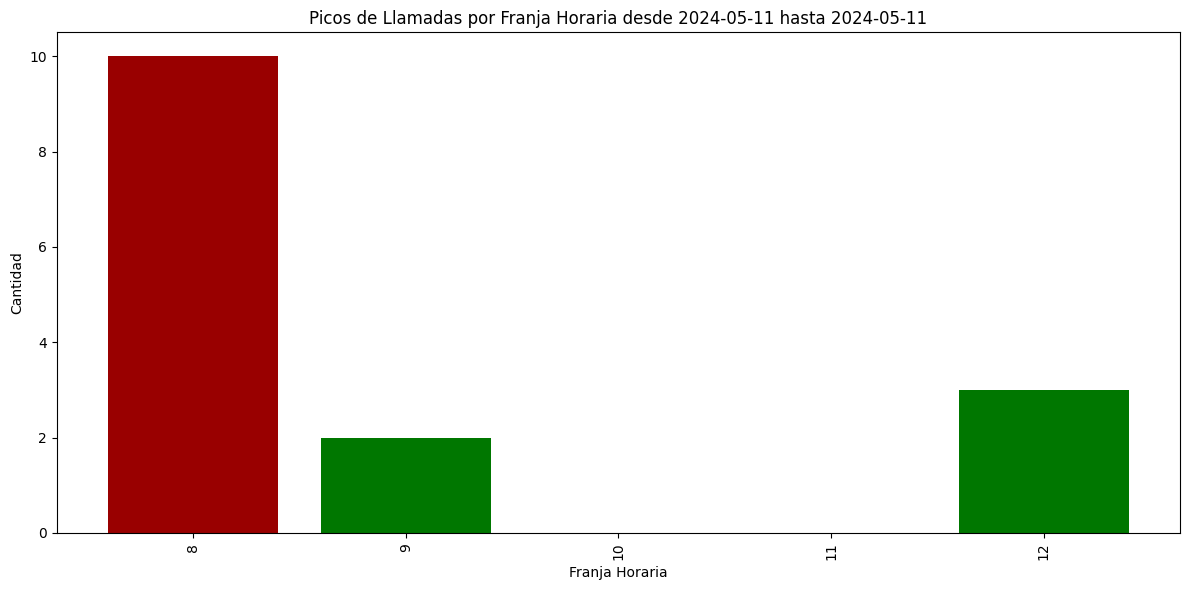

In [10]:
# Filtrar los registros donde la dirección sea "IN" / "OUT"
df = df[df['Direccion'] == 'IN']
"""df_in = df[df['Direccion'] == 'IN']
df_out = df[df['Direccion'] == 'OUT']"""

# Obtener los datos de conteo y ordenarlos
"""counts = df_in['FranjaHoraria'].value_counts().sort_index()"""
counts = df['FranjaHoraria'].value_counts().sort_index()

# Definir los colores para el mapa de calor
colors = np.array(['#ECECEC'] * len(counts))

# Calcular los umbrales en función de los porcentajes
percentage_thresholds = [40, 75, 100]  # Porcentajes para los umbrales

# Calcular los umbrales basados en los porcentajes
max_count = counts.max()
thresholds = [max_count * (p / 100) for p in percentage_thresholds]

# Definir los colores correspondientes
color_palette = ['#007700', '#FFFF00', '#990000']  # Verde, Amarillo, Rojo FF0000

# Asignar colores diferentes a los rangos de valores
for i in range(len(thresholds)):
    if i == 0:
        colors[counts <= thresholds[i]] = color_palette[i]
    else:
        colors[(counts > thresholds[i-1]) & (counts <= thresholds[i])] = color_palette[i]

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de acuerdo a tus preferencias

# Reducir el tamaño de la fuente de las etiquetas del eje x
plt.xticks(fontsize=10, rotation=90)

# Crear el gráfico de barras con colores
plt.bar(counts.index, counts.values, color=colors)

# Personalizar las etiquetas y el título
plt.xlabel('Franja Horaria')
plt.ylabel('Cantidad')
plt.title(f'Picos de Llamadas por Franja Horaria desde {fecha_minima} hasta {fecha_maxima}')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el espaciado
plt.show()

## Duración de la llamadas según Franja Horaria.

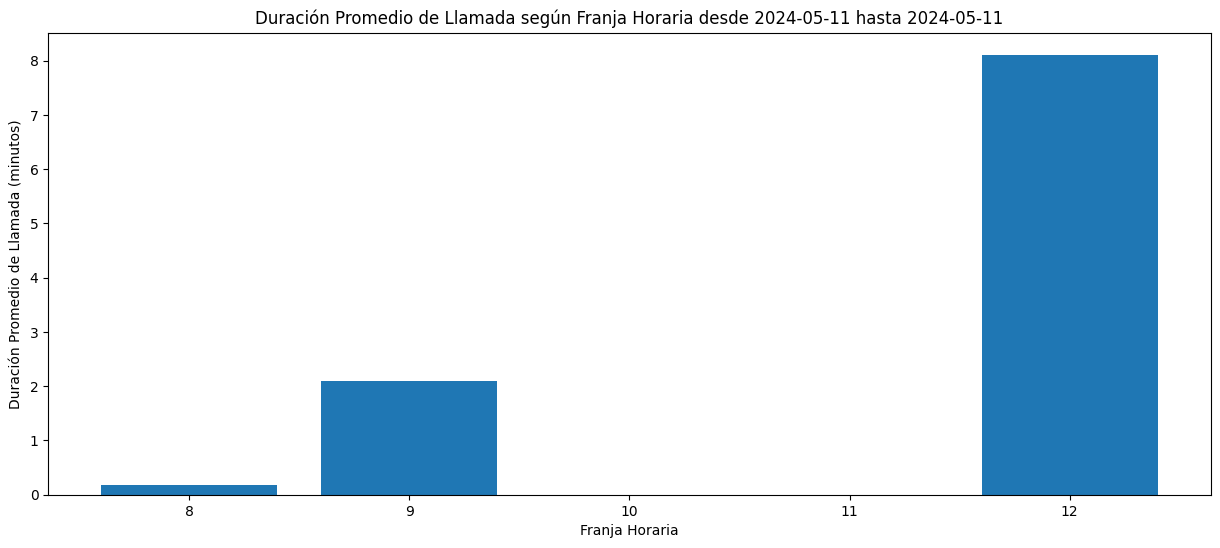

In [11]:
# Nos interesa saber si la duracion de la llamada varia segun el momento del dia

# Agrupar y calcular la duración promedio de las llamadas por franja horaria se agregó la posibilidad de visualizar
#  3 opciones histórico, por Mes o por Dia.
duration_by_hour = df.groupby('FranjaHoraria')['DuracionT'].mean()

# Convertir los valores de duración de segundos a minutos
duration_by_hour = duration_by_hour / 60

# Ordenar los valores por franja horaria
duration_by_hour = duration_by_hour.sort_index()

# Ajustar el tamaño de la figura
plt.figure(figsize=(15, 6))  # Ajusta el tamaño de acuerdo a tus preferencias

# Crear el gráfico de barras
plt.bar(duration_by_hour.index, duration_by_hour.values)


# Personalizar las etiquetas y el título
plt.xlabel('Franja Horaria')
plt.ylabel('Duración Promedio de Llamada (minutos)')
plt.title(f'Duración Promedio de Llamada según Franja Horaria desde {fecha_minima} hasta {fecha_maxima}')

# Mostrar el gráfico
plt.show()

## Duración de la llamada de acuerdo al usuario

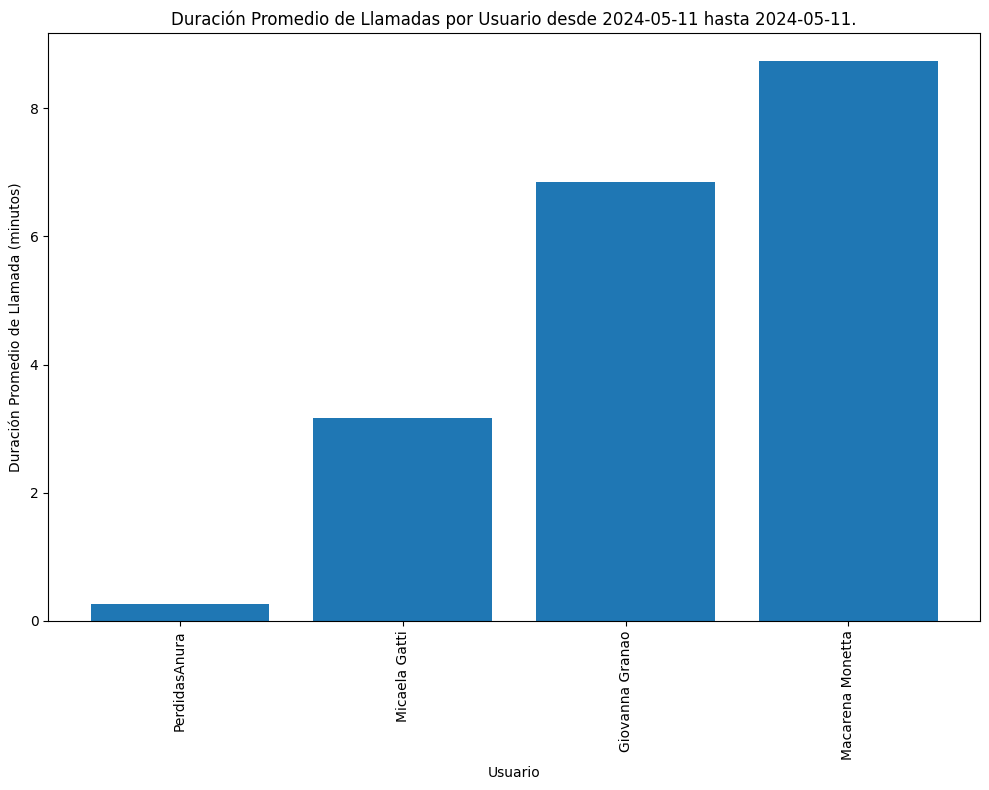

In [12]:
# Agrupar y calcular la duración promedio de las llamadas por usuario
duration_by_user = df.groupby('CuentaContesto')['DuracionT'].mean() # el dataframe df no descrimina IN y OUT.

# Convertir los valores de duración de segundos a minutos
duration_by_user = duration_by_user / 60

# Ordenar los valores por duración promedio
duration_by_user = duration_by_user.sort_values()

# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de acuerdo a tus preferencias

# Crear el gráfico de barras
plt.bar(duration_by_user.index, duration_by_user.values)

# Personalizar las etiquetas y el título
plt.xlabel('Usuario')
plt.ylabel('Duración Promedio de Llamada (minutos)')
plt.title(f'Duración Promedio de Llamadas por Usuario desde {fecha_minima} hasta {fecha_maxima}.')

# Mostrar el gráfico
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.tight_layout()  # Ajustar el espaciado
plt.show()

## Gráfico Boxplot tiempos en llamadas.

* Gráfico de caja y bigotes de la duración de las llamadas por usuario.
* Cada caja representa el rango intercuartil (IQR), donde la línea central es la mediana, el borde inferior de la caja es el primer cuartil (Q1), el borde superior es el tercer cuartil (Q3) y los bigotes indican el rango de valores típicos.
* Los puntos más allá de los bigotes se consideran outliers.

<Figure size 2400x1500 with 0 Axes>

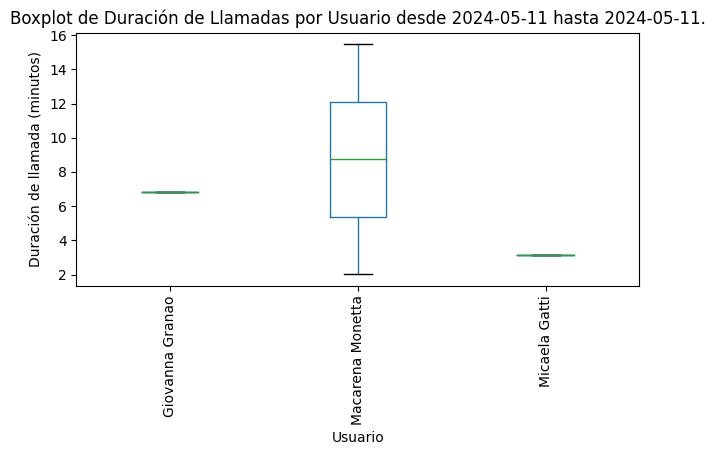

In [13]:

# Convertir la duración de la llamada a minutos
df['DuracionMin'] = df['DuracionT'] / 60
df = df[df['CuentaContesto'] != 'PerdidasAnura']  # quitamos los registros etiquetados como perdidas Anura ya que no valen la pena trabajarlos.

# Graficar boxplot de duración por usuario
plt.figure(figsize=(24, 15))  # Ajustar tamaño de la figura según tus preferencias

df.boxplot(column='DuracionMin', by='CuentaContesto')

plt.xlabel('Usuario')
plt.ylabel('Duración de llamada (minutos)')
plt.title(f'Boxplot de Duración de Llamadas por Usuario desde {fecha_minima} hasta {fecha_maxima}.')
plt.suptitle('')  # Eliminar título automático generado por Pandas

# Rotar las etiquetas del eje X a 90 grados
plt.xticks(rotation=90)

# Desactivar las grillas en el gráfico
plt.grid(False)

# Ajustar el espacio entre los subplots
plt.tight_layout()

plt.show()


## Cantidad de llamadas por turno.

* Turno 1 (mañana 8 a 16:59) y
* turno 2 (tarde 17 a 20).



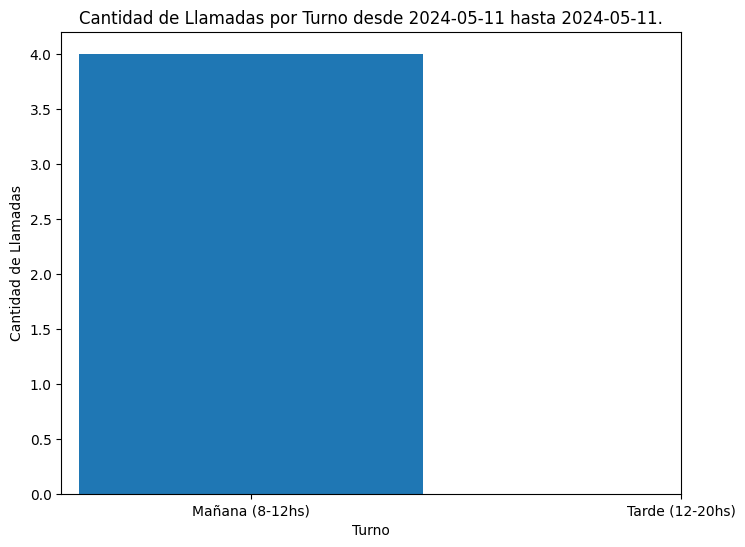

In [14]:
# Calcular el conteo de llamadas por turno
counts = df['Turno-Tel'].value_counts().sort_index()
"""counts = df['Turno-Tel_2'].value_counts().sort_index()"""

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))  # Ajustar tamaño de la figura según tus preferencias
plt.bar(counts.index, counts.values)

# Personalizar las etiquetas y el título
plt.xlabel('Turno')
plt.ylabel('Cantidad de Llamadas')
plt.title(f'Cantidad de Llamadas por Turno desde {fecha_minima} hasta {fecha_maxima}.')

# Etiquetar los valores 1 y 2 como "Mañana" y "Tarde"
plt.xticks([1, 2], ['Mañana (8-12hs)', 'Tarde (12-20hs)'])

# Mostrar la gráfica
plt.show()

**Armar informe para pasar al Equipo de Soporte.**

1.   Distribución del 100% de las llamadas recibidas. Se incluyen las llamadas perdidas distribuidas en porcentajes %.





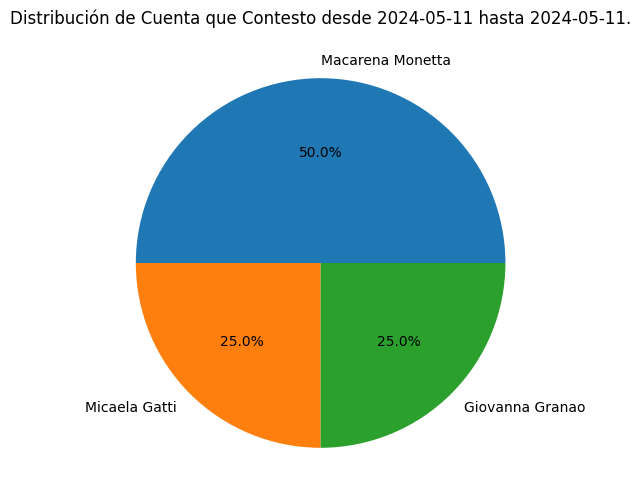

In [15]:
# Calcular la cantidad de llamadas para cada CuentaContesto en enero de 2023 o el mes que defina
counts = df['CuentaContesto'].value_counts()

# Para poder analizar los resultados exporto a un archivo de excel.
"""df_marzo_2023.to_excel('df_marzo_2023.xlsx', index=False)"""

# Crear el gráfico de torta
plt.figure(figsize=(8, 6))  # Ajustar tamaño de la figura según tus preferencias
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')

"""plt.pie(counts, labels=counts.index, autopct='%1.1f%%', labeldistance=10.1)  # Aumenta la distancia de las etiquetas del centro """
"""plt.xticks(fontsize=10)  # Ajusta el tamaño de la fuente de las etiquetas"""


# Personalizar el título
plt.title(f'Distribución de Cuenta que Contesto desde {fecha_minima} hasta {fecha_maxima}.')

# Mostrar el gráfico
plt.show()


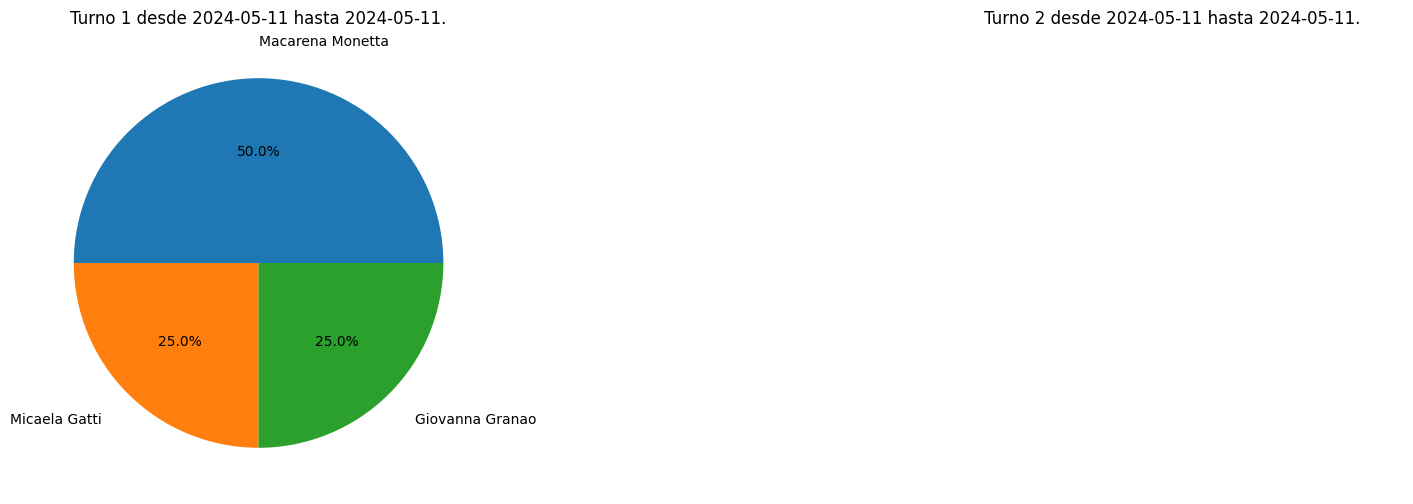

In [16]:
# Calcular la cantidad de llamadas para cada CuentaContesto en cada turno
counts_turno1 = df[df['Turno-Tel'] == 1]['CuentaContesto'].value_counts()
counts_turno2 = df[df['Turno-Tel'] == 2]['CuentaContesto'].value_counts()

# Crear dos gráficos de torta, uno para cada turno
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

# Ajustar el espacio horizontal entre los subplots
plt.subplots_adjust(wspace=0.9)

# Graficar el primer turno
ax1.pie(counts_turno1, labels=counts_turno1.index, autopct='%1.1f%%', labeldistance=1.2) # labeldistance mueve las etiquetas hacia afuera de la gráfica.
ax1.set_title(f'Turno 1 desde {fecha_minima} hasta {fecha_maxima}.')

# Graficar el segundo turno
ax2.pie(counts_turno2, labels=counts_turno2.index, autopct='%1.1f%%')
ax2.set_title(f'Turno 2 desde {fecha_minima} hasta {fecha_maxima}.')

# Mostrar los gráficos
plt.show()


## Números que llaman y NO vuelven a comunicarse por día.

In [17]:
# Llamadas Perdidas. En el rango establecido y según ANURA.

print(df[df['CuentaContesto'] == 'PerdidasAnura']['CuentaContesto'].value_counts())


Series([], Name: count, dtype: int64)


In [18]:
# Armo el DS agregando el campo "CuentaContesto_bis" para poder utilizarlo luego
df['CuentaContesto_bis'] = df['CuentaContesto']
df = df[['Nro. Origen ', 'Origen ', 'DuracionT', 'DuracionConv', 'Tiempo espera', 'CuentaContesto', 'CuentaContesto_bis', 'TerminalContesto', 'Fecha', 'Hora', 'FranjaHoraria', 'Turno', 'Turno-Tel', 'DiaSemana', 'DuracionMin']]
df.head(5)

,Nro. Origen,Origen,DuracionT,DuracionConv,Tiempo espera,CuentaContesto,CuentaContesto_bis,TerminalContesto,Fecha,Hora,FranjaHoraria,Turno,Turno-Tel,DiaSemana,DuracionMin
50302,3482512537,Argentina/RECONQUISTA - MOVIL,190,190,0,Micaela Gatti,Micaela Gatti,softphone-106,2024-05-11,09:41:46.736000,9,1,1,Saturday,3.166667
50303,3454221055,Argentina/CONCORDIA - FIJO,928,928,0,Macarena Monetta,Macarena Monetta,softphone-112,2024-05-11,12:07:41.587000,12,1,1,Saturday,15.466667
50304,1124488118,Argentina/AMBA - MOVIL,411,411,0,Giovanna Granao,Giovanna Granao,softphone-110,2024-05-11,12:13:41.695000,12,1,1,Saturday,6.850000
50305,1124488118,Argentina/AMBA - MOVIL,121,121,0,Macarena Monetta,Macarena Monetta,softphone-112,2024-05-11,12:29:21.460000,12,1,1,Saturday,2.016667


In [19]:
# Generamos un Data Set que me permita trabajar 'CuentaContesto'
# Seteamos con valor 0 si = "PerdidasAnura"
# Seteamos con valor 1 si =! "PerdidasAnura"

df_perdidas = df.copy()
df_perdidas['CuentaContesto'] = df_perdidas['CuentaContesto'].apply(lambda x: 0 if x == 'PerdidasAnura' else 1)

# Genero el archivo de Excel para poder validar los datos que obtengo.
df_perdidas.to_excel('dfperdidas_con_rango.xlsx', index=False)

In [20]:
#df_perdidas.head(15)
#df_perdidas.dtypes # visualiza los tipos
df_perdidas.shape

(4, 15)

In [21]:
def add_diccionario_lista():
  """Esta función agrega los elementos del diccionario NoAtendidas a la lista
  lista_perdidas.
  Parámetros: No tiene """
  for clave, valor in NoAtendidas.items():
    lista_perdidas.append((clave, valor))

NoAtendidas = {} # Inicializo el diccionario.
lista_perdidas = [] # Inicializo la lista de llamadas perdidas.
fecha_band = df_perdidas.iloc[0].Fecha # genero bandera de la posición 1 del archivo de perdidas.


# Comienzo a iterar sobre el df_perdidas para ir trabajando las llamadas perdidas por día
for index, row in df_perdidas.iterrows():
    nro = row['Nro. Origen ']
    atendido = row['CuentaContesto']
    fecha = row['Fecha']

    if fecha_band != fecha: # Voy verificando la fecha para determinar análisis por día, considerando que el rango de fecha puede incluir varios días.
        fecha_band = fecha

        add_diccionario_lista()

        # Limpiar el diccionario NoAtendidas para iniciar un nuevo día
        NoAtendidas.clear()

    if atendido == 0:
        if nro not in NoAtendidas:
            NoAtendidas[nro] = fecha
    elif atendido == 1 and nro in NoAtendidas:
        del NoAtendidas[nro]

add_diccionario_lista()


# Crear un DataFrame a partir de la lista
NoAtendidas_df = pd.DataFrame(lista_perdidas, columns=['Nro. Teléfono', 'Fecha'])

# Imprimir el DataFrame resultante
print(NoAtendidas_df)


Empty DataFrame
Columns: [Nro. Teléfono, Fecha]
Index: []


               Llamadas  Cantidad  Porcentaje
0  Cantidad de llamadas         4       100.0
1             Atendidas         4       100.0
2              Ocupadas         0         0.0
3       Perdidas Reales         0         0.0


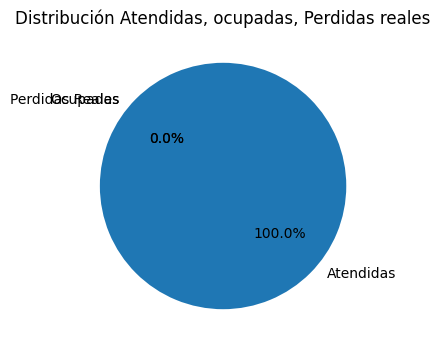

In [22]:
# Calculos para informe de llamadas.
# ---------------------------------------------------------------------------------------
# Obtener la cantidad de registros en el dataframe
total_registros = len(df_perdidas)

# Obtener la cantidad de llamadas atendidas
llamadas_atendidas = df_perdidas[df_perdidas['CuentaContesto'] == 1]
cantidad_atendidas = len(llamadas_atendidas)

# Obtener la cantidad de llamadas no atendidas
"""cantidad_no_atendidas = len(NoAtendidas)"""
cantidad_no_atendidas = len(lista_perdidas)

#Cantidad de llamadas "ocupado" (llamaron y sono .. sono ó cortaron)
cantidad_ocupado = total_registros - cantidad_atendidas

# Calcular el porcentaje de cada variable
porcentaje_registros = (total_registros / total_registros) * 100
porcentaje_atendidas = (cantidad_atendidas / total_registros) * 100
porcentaje_ocupado = porcentaje_registros - porcentaje_atendidas # sumé esta línea para poder representar la cantidad de llamadas en estado "ocupado" """///////////////////////"""
porcentaje_no_atendidas = (cantidad_no_atendidas / total_registros) * 100

# Crear un dataframe con los resultados
informe = pd.DataFrame({
    'Llamadas': ['Cantidad de llamadas','Atendidas','Ocupadas', 'Perdidas Reales'],
    'Cantidad': [total_registros,cantidad_atendidas, cantidad_ocupado, cantidad_no_atendidas],
    'Porcentaje': [porcentaje_registros, porcentaje_atendidas, porcentaje_ocupado, porcentaje_no_atendidas]
})

# Creamos un dataframe que permita visualizar focalizando en 'Atendidas','Ocupadas' y 'Perdidas Reales.
informe_grafico = pd.DataFrame({
    'Llamadas': ['Atendidas', 'Ocupadas', 'Perdidas Reales'],
    'Porcentaje': [porcentaje_atendidas, porcentaje_ocupado, porcentaje_no_atendidas]
})


# Mostrar el informe
print(informe)


# Crear un gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(informe_grafico['Porcentaje'], labels=informe_grafico['Llamadas'], autopct='%1.1f%%', startangle=140)
plt.title('Distribución Atendidas, ocupadas, Perdidas reales')
plt.show()


# Mostrar el gráfico de torta
plt.show()



**Distribución de la atención de llamadas en Equipo de Soporte**

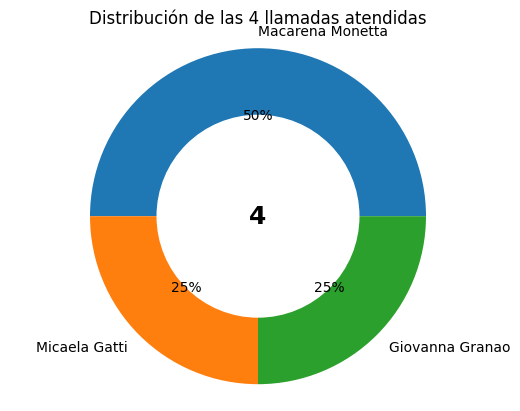

In [23]:
# Distribución por recurso de las llamadas Perdidas

import matplotlib.pyplot as plt

df_filtered = df[df['CuentaContesto'] != 'PerdidasAnura']
count_values = df_filtered['CuentaContesto_bis'].value_counts()
labels = count_values.index.tolist()
values = count_values.values.tolist()

plt.pie(values, labels=labels, autopct='%1.0f%%')
plt.axis('equal')


# Agregar círculo blanco en el medio del gráfico
circle = plt.Circle((0, 0), 0.6, color='white')
plt.gca().add_artist(circle)

# Agregar etiquetas con la cantidad total de cada valor
total_calls = sum(values)
count = 0
for i, label in enumerate(labels):
    count = values[i] + count
    #plt.text(0, 0, f'{count}', ha='center', va='center', fontsize=12, fontweight='bold')

plt.text(0, 0, f'{count}', ha='center', va='center', fontsize=18,fontweight='bold')

plt.title(f'Distribución de las {count} llamadas atendidas')
plt.show()


**Ranking** de llamados telefónicos.



In [24]:
# Cuantas veces llama un número telefónico
# Habría que armar un Ranking 10 ó 20

# frec = df["Nro. Origen "].value_counts()
frec = df.groupby("Origen ")["Nro. Origen "].value_counts().sort_index(ascending=False).sort_values(ascending=False)

# Convertir la Serie resultante a DataFrame y agregar la columna "cantidad"
frec_df = frec.reset_index(name='Cantidad')

# Genero el archivo Excel para poder trabajarlo y hacer los informes
frec_df.to_excel('ranking_llamadas.xlsx', index=True)

# Visualizo el data frame (ranking) generado
frec_df.head(20) # podemos visualizar un total de 60  utilizando esto "frec.head(60)"

,Origen,Nro. Origen,Cantidad
0,Argentina/AMBA - MOVIL,1124488118,2
1,Argentina/RECONQUISTA - MOVIL,3482512537,1
2,Argentina/CONCORDIA - FIJO,3454221055,1
